# 2) PMI (Pointwise Mutual Information)

This notebook is part of **Applied NLP – Session 2: Phrases & Collocations**.

Overview:
- Compute pointwise mutual information (PMI) for bigrams in two works by the same author.
- Use PMI to surface word pairs that co-occur more often than expected by chance, then inspect frequency to avoid noise.

Learning objectives:
- Estimate unigram and bigram probabilities from counts and compute PMI.
- Apply frequency thresholds to reduce spurious high-PMI rare pairs.
- Visualize and export the top PMI bigrams as CSV and PNG for reporting.

Quick start:
1. Edit the `CONFIG` dictionary below to point to your two plain-text books.
2. Optionally enable `use_stopwords` or provide a `STOPWORDS` set to remove function words.
3. Run the notebook cells in order. Outputs are saved to `../results/PMI_table.csv` and `../results/PMI_figure.png`.

Prerequisites:
- A Python environment with requirements.txt requirements installed.
- The two text files placed in `../data/`.

Notes and tips:
- PMI can highlight informative collocations but is sensitive to low counts. Use `min_ngram_count` to filter rare bigrams.
- If you want consistent preprocessing across notebooks, copy the preprocessing cell from notebook 1 (Gutenberg stripping, curly-quote normalization, and the single-letter token prune).

Tips from notebook 1:
- The notebooks normalize curly quotes and prune single-letter tokens (except `a` and `i`) to avoid spurious n-grams such as `alice q s`.
- If you run into unexpected tokens, run the preprocessing/inspection cells from notebook 1 to diagnose and repair encoding issues.


## 0. Setup & Configuration

- Fill the `CONFIG` paths for your two books (plain text).
- Toggle stopwords and thresholds as needed.


In [1]:
# ===== Imports & Config =====
import re, os, math, json, collections
from pathlib import Path
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (9, 4.5)
plt.rcParams["axes.grid"] = True

CONFIG = {
    "book1_path": "..\\data\\Fellowship.txt",
    "book2_path": "..\\data\\TwoTowers.txt",
    "book3_path": "..\\data\\TheKing.txt",
    "language": "en",                # e.g. 'en','de','ru','el'
    "use_stopwords": False,          # toggle
    "min_ngram_count": 5,            # threshold (where applicable)
    "top_k": 20                      # top items to show
}

# Unicode-aware token regex: words with optional internal ' or -
WORD_RE = re.compile(r"[^\W\d_]+(?:[-'][^\W\d_]+)*", flags=re.UNICODE)

# Optional: supply your own stopwords set per language
STOPWORDS = set()


## 1. Load & Normalize Text

- Fix hyphenated line breaks (e.g., end-of-line hyphens).
- Normalize whitespace.
- Lowercase consistently.

Our books are a part of Project Gutenberg, which means there are some extra texts in each txt file to be cleaned.

In [2]:
# --- Robust Project Gutenberg boilerplate stripper --------------------------
_GB_START_MARKERS = [
    r"\*\*\*\s*START OF (THIS|THE) PROJECT GUTENBERG EBOOK",   # modern
    r"START OF (THIS|THE) PROJECT GUTENBERG EBOOK",             # fallback
    r"End of the Project Gutenberg(?:'s)? Etext",               # very old variants sometimes inverted
]
_GB_END_MARKERS = [
    r"\*\*\*\s*END OF (THIS|THE) PROJECT GUTENBERG EBOOK",      # modern
    r"END OF (THIS|THE) PROJECT GUTENBERG EBOOK",                # fallback
    r"End of Project Gutenberg(?:'s)? (?:Etext|eBook)",          # older variants
    r"\*\*\*\s*END: FULL LICENSE\s*\*\*\*",                      # license block end (older)
]

# Chapters (heuristic fallback if markers missing; English-centric but works often)
_CHAPTER_HINTS = [
    r"^\s*chapter\s+[ivxlcdm0-9]+[\.\: ]",   # CHAPTER I / Chapter 1
    r"^\s*book\s+[ivxlcdm0-9]+[\.\: ]",      # BOOK I etc.
    r"^\s*part\s+[ivxlcdm0-9]+[\.\: ]",
]

def strip_gutenberg(text: str) -> str:
    """
    Returns text between Gutenberg START and END markers (case-insensitive).
    If markers aren't found, heuristically trims to first chapter-like heading.
    Works for most EN/DE/RU/EL releases since headers are in English.
    """
    t = text.replace("\ufeff", "")  # strip BOM if present

    # Find START
    start_idx = None
    for pat in _GB_START_MARKERS:
        m = re.search(pat, t, flags=re.IGNORECASE)
        if m:
            # start AFTER the matched line
            start_idx = t.find("\n", m.end())
            if start_idx == -1:
                start_idx = m.end()
            break

    # Find END
    end_idx = None
    for pat in _GB_END_MARKERS:
        m = re.search(pat, t, flags=re.IGNORECASE)
        if m:
            # end BEFORE the matched line
            end_idx = m.start()
            break

    if start_idx is not None and end_idx is not None and end_idx > start_idx:
        core = t[start_idx:end_idx]
    else:
        # Fallback: try to start at first chapter-like heading
        core = t
        for pat in _CHAPTER_HINTS:
            m = re.search(pat, core, flags=re.IGNORECASE | re.MULTILINE)
            if m:
                core = core[m.start():]
                break
        # And trim off the standard license tail if present
        for pat in _GB_END_MARKERS:
            m = re.search(pat, core, flags=re.IGNORECASE)
            if m:
                core = core[:m.start()]
                break

    # Remove license/contact blocks that sometimes sneak inside
    core = re.sub(r"\n\s*End of the Project Gutenberg.*", "", core, flags=re.IGNORECASE)
    core = re.sub(r"\*\*\*\s*START: FULL LICENSE\s*\*\*\*.*", "", core, flags=re.IGNORECASE | re.DOTALL)

    # Clean leftover cruft: URLs, repeated separators
    core = re.sub(r"https?://\S+", "", core)
    core = re.sub(r"[ \t]+\n", "\n", core)   # trailing spaces before newline
    core = re.sub(r"\n{3,}", "\n\n", core)   # collapse big blank blocks
    return core.strip()


In [3]:
def load_text(p: str) -> str:
    with open(p, "r", encoding="utf-8", errors="ignore") as f:
        return f.read()

def normalize_text(t: str) -> str:
    # 1) strip Gutenberg header/footer FIRST
    # This removes license text and front/back matter that would otherwise pollute counts.
    t = strip_gutenberg(t)
    # 1.5) Normalize smart/curly apostrophes to ASCII apostrophe so contractions
    # (e.g., don’t) are preserved as single tokens rather than split into
    # two tokens (don t). This handles U+2019 (right single quotation mark) and
    # U+2018 (left single quotation mark) commonly found in some texts/encodings.
    t = t.replace("’", "'")
    t = t.replace("‘", "'")
    # 2) join hyphenated line breaks (e.g., "won-\nderful")
    t = re.sub(r"-\s*\n", "", t)
    # 3) normalize whitespace
    t = re.sub(r"\s+", " ", t)
    return t

text1 = normalize_text(load_text(CONFIG["book1_path"]))
text2 = normalize_text(load_text(CONFIG["book2_path"]))
text3 = normalize_text(load_text(CONFIG["book3_path"]))

tokens1 = WORD_RE.findall(text1.lower())
tokens2 = WORD_RE.findall(text2.lower())
tokens3 = WORD_RE.findall(text3.lower())

if CONFIG["use_stopwords"]:
    tokens1 = [t for t in tokens1 if t not in STOPWORDS]
    tokens2 = [t for t in tokens2 if t not in STOPWORDS]
    tokens3 = [t for t in tokens3 if t not in STOPWORDS]

tokens = tokens1 + tokens2 + tokens3

len(tokens1), len(tokens2), len(tokens3), len(tokens)

(187201, 153824, 135180, 476205)

In [4]:
# # Diagnostic: list most frequent 1- and 2-letter tokens and show raw contexts
# from collections import Counter
# short_counts = Counter(t for t in tokens if len(t) <= 2)
# print('Top short tokens (len<=2):')
# for tok, c in short_counts.most_common(30):
#     print(f'{tok!r}: {c}')

# # Show example contexts for top few short tokens
# def show_contexts(tok, max_examples=5, window=30):
#     examples = []
#      #    raw = load_text(CONFIG['book1_path']) + '\n---BOOK2---\n' + load_text(CONFIG['book2_path']) + '\n---BOOK3---\n' + load_text(CONFIG['book3_path'])
#     # find in token sequence positions in combined tokens and map to approximate char positions by naive search
#     joined = ' '.join(tokens)
#     start = 0
#     found = 0
#     for m in re.finditer(re.escape(tok), joined):
#         if found >= max_examples: break
#         pos = m.start()
#         # approximate slice from joined tokens may be enough for inspection
#         s = joined[max(0,pos-window): pos+window]
#         print('  context:', repr(s))
#         found += 1
#     if found == 0:
#         print('  (no simple joined-token context found)')

# for tok, _ in short_counts.most_common(10):
#     print('\nExamples for token:', tok)
#     show_contexts(tok)

# print('Diagnostic complete. If a short token is spurious (e.g., "q", "s", "th"), consider pruning it.')

In [5]:
# Prune short tokens: keep only 'a' and 'i' for length 1, and a whitelist for length 2
keep_1 = {'a', 'i'}
# Common 2-letter English words to keep; extend if you need more
keep_2 = {'of','to','in','on','by','an','or','as','is','it','we','us','he','me','my','so','be','do','no','at','up','if','go','am','oh'}

# Apply pruning to per-book tokens if present
# Apply pruning to per-book tokens if present
if 'tokens1' in globals() and 'tokens2' in globals() and 'tokens3' in globals():
    tokens1 = [t for t in tokens1 if (len(t) > 2) or (len(t) == 1 and t in keep_1) or (len(t) == 2 and t in keep_2)]
    tokens2 = [t for t in tokens2 if (len(t) > 2) or (len(t) == 1 and t in keep_1) or (len(t) == 2 and t in keep_2)]
    tokens3 = [t for t in tokens3 if (len(t) > 2) or (len(t) == 1 and t in keep_1) or (len(t) == 2 and t in keep_2)]
    tokens = tokens1 + tokens2 + tokens3
else:
    tokens = [t for t in tokens if (len(t) > 2) or (len(t) == 1 and t in keep_1) or (len(t) == 2 and t in keep_2)]

print('After pruning: counts ->', 'tokens1=' + str(len(tokens1)) if 'tokens1' in globals() else '', 'tokens=' + str(len(tokens)))
# Show remaining short tokens (sanity check)
from collections import Counter
sc = Counter(t for t in tokens if len(t) <= 2)
print('Remaining short tokens:', sc.most_common(30))

After pruning: counts -> tokens1=186875 tokens=475430
Remaining short tokens: [('of', 13036), ('to', 9968), ('a', 9185), ('he', 7961), ('in', 7289), ('it', 6398), ('i', 6168), ('as', 3465), ('is', 3297), ('at', 3049), ('on', 3038), ('we', 2512), ('be', 2253), ('if', 1927), ('no', 1859), ('or', 1784), ('up', 1623), ('by', 1350), ('my', 1331), ('so', 1322), ('do', 1302), ('me', 1239), ('go', 1043), ('us', 882), ('an', 735), ('am', 473), ('oh', 39)]


## 2. Unigram & Bigram Counts

We estimate probabilities from observed counts, then compute PMI:

\[ \text{PMI}(w_i, w_{i+1}) = \log_2 \frac{p(w_i, w_{i+1})}{p(w_i)\,p(w_{i+1})} \]

To reduce noise, filter out rare bigrams with `min_ngram_count`.


In [6]:
unigrams = Counter(tokens)
bigrams = Counter(zip(tokens, tokens[1:]))

N1 = sum(unigrams.values())
N2 = sum(bigrams.values())

min_c = CONFIG["min_ngram_count"]
bigrams_f = {bg:c for bg,c in bigrams.items() if c >= min_c}

def pmi(a, b):
    pa = unigrams[a] / N1 if N1 else 0
    pb = unigrams[b] / N1 if N1 else 0
    pab = bigrams[(a,b)] / N2 if N2 else 0
    if pa <= 0 or pb <= 0 or pab <= 0:
        return float("-inf")
    return math.log2(pab / (pa * pb))

rows = []
for (a,b), c in bigrams_f.items():
    rows.append({"bigram": f"{a} {b}", "count": c, "PMI": pmi(a,b)})

pmi_df = (pd.DataFrame(rows)
          .replace([float("inf"), float("-inf")], pd.NA)
          .dropna()
          .sort_values(["PMI","count"], ascending=[False, False])
          .head(CONFIG["top_k"]))
pmi_df.reset_index(drop=True)

,bigram,count,PMI
0,nan curunír,5,16.536948
1,caras galadhon,8,15.858876
2,sammath naur,5,15.858876
3,henneth annûn,8,15.688951
4,rath dínen,8,15.688951
5,ered lithui,5,15.688951
6,parth galen,10,15.536948
7,sarn gebir,9,15.273914
8,cair andros,12,15.158437
9,tol brandir,14,15.051522


## 3. Visualize Top PMI Bigrams

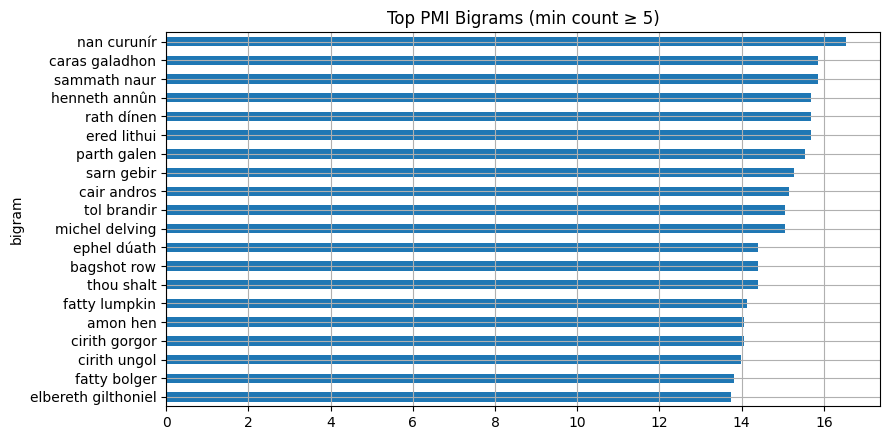

In [7]:
ax = pmi_df.plot.barh(x="bigram", y="PMI", legend=False)
ax.invert_yaxis()
ax.set_title(f"Top PMI Bigrams (min count ≥ {min_c})")
# Keep a reference to the Figure so we can save it reliably later (avoids empty canvas)
fig_pmi = ax.get_figure()
plt.tight_layout(); plt.show()

## 4. Notes

- High PMI indicates stronger-than-chance association.
- Inspect frequency too; very rare but high-PMI can still be noise.


## 5. Reflection (Answer in your repo's README or below)

- Which results matched your reading intuition?
- What surprised you?
- If you toggled preprocessing (stopwords on/off), what changed?
- Compare across the two works: are the patterns stable?

## 6. Export (tables/figures)

This cell saves outputs into the `../results/` folder so you can add them to your report.


In [8]:
Path("../results").mkdir(exist_ok=True)
pmi_df.to_csv(f"../results/PMI_table.csv", index=False)
# Prefer saving via the captured Figure object to avoid backend/display issues.
try:
    fig_pmi.savefig(f"../results/PMI_figure.png", dpi=200, bbox_inches="tight")
except NameError:
    # fig_pmi not defined (plot cell may not have been run); fall back to pyplot save
    try:
        plt.savefig(f"../results/PMI_figure.png", dpi=200, bbox_inches="tight")
    except Exception:
        pass
